In [47]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import pydicom

from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler,LabelEncoder, label_binarize
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, roc_auc_score

from imblearn.over_sampling import RandomOverSampler
import torch
from torch.utils.data import Dataset, DataLoader,TensorDataset
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt
import seaborn as sns

from helpers import get_ddsm_table, get_INBreast_table, get_VinDR_table, mask_image, run_intensity_functions, run_glcm_features, get_master_df

load = True
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

<h3>Load and Process Data</h3>

In [2]:
ddsm_df = get_ddsm_table("/Volumes/OS/Users/tahaa/Data Science/DataSets/PMSD/DDSM")
INbreast_df = get_INBreast_table("/Volumes/OS/Users/tahaa/Data Science/DataSets/PMSD/INbreast Release 1.0")
vindr_df = get_VinDR_table("/Volumes/OS/Users/tahaa/Data Science/DataSets/PMSD/VinDr")

In [3]:
master_df = get_master_df(vindr_df, ddsm_df, INbreast_df)

In [9]:
df_data = []
for i in tqdm(range(len(master_df))):
    row = master_df.iloc[i]
    image_stats = {
        "file_name": row['full_path'],
        "vendor": row['Manufacturer'],
        "laterality": row['laterality'], 
        "view_position": row['view_position'],
        "breast_density": row['breast_density']    
    }
    pixel_array = pydicom.dcmread(row['full_path']).pixel_array
    breast_tissue_image = mask_image(pixel_array)
    intensity_stats, hist_features = run_intensity_functions(breast_tissue_image)
    image_stats.update(intensity_stats)
    image_stats.update(hist_features)
    glcm_stats = run_glcm_features(breast_tissue_image)
    image_stats.update(glcm_stats)
    df_data.append(image_stats)

image_stats_df = pd.DataFrame(df_data)


100%|██████████| 2381/2381 [15:21<00:00,  2.59it/s]


In [10]:
image_stats_df.to_csv('complete_stats_normalized.csv', index=False)

In [2]:
if(load):
    image_stats_df = pd.read_csv('complete_stats_normalized.csv')

In [3]:
image_stats_df.head()

,file_name,vendor,laterality,view_position,breast_density,mean,max,min,std,median,skew,kurtosis,area_under_histogram,hist_1,bin_1,hist_2,bin_2,hist_3,bin_3,hist_4,bin_4,hist_5,bin_5,hist_6,bin_6,hist_7,bin_7,hist_8,bin_8,hist_9,bin_9,hist_10,bin_10,hist_11,bin_11,hist_12,bin_12,hist_13,bin_13,hist_14,bin_14,hist_15,bin_15,hist_16,bin_16,homogeneity_1,correlation_1,contrast_1,dissimilarity_1,ASM_1,energy_1,homogeneity_2,correlation_2,contrast_2,dissimilarity_2,ASM_2,energy_2,homogeneity_3,correlation_3,contrast_3,dissimilarity_3,ASM_3,energy_3
0,/Volumes/OS/Users/tahaa/Data Science/DataSets/...,SIEMENS,L,CC,DENSITY C,0.593502,1.0,0.000447,0.132428,0.597142,-0.669600,0.871504,1857677.5,674,0.000447,3326,0.062919,8606,0.125391,20687,0.187863,38302,0.250335,63166,0.312807,96455,0.375279,114162,0.437751,252957,0.500223,527965,0.562695,284133,0.625167,266435,0.687640,122681,0.750112,48338,0.812584,9694,0.875056,867,0.937528,0.116832,0.885412,240.804556,10.001721,0.000324,0.017999,0.059435,0.559002,838.794271,21.236752,0.000184,0.013550,0.042107,0.206805,1560.824828,30.075758,0.000124,0.011143
1,/Volumes/OS/Users/tahaa/Data Science/DataSets/...,SIEMENS,L,MLO,DENSITY C,0.530756,1.0,0.000857,0.139187,0.528908,-0.280610,-0.185952,2877795.5,565,0.000857,8596,0.063303,22765,0.125749,49681,0.188196,122092,0.250642,203739,0.313089,265951,0.375535,485701,0.437982,545334,0.500428,368759,0.562875,395372,0.625321,299002,0.687768,82354,0.750214,25157,0.812661,2878,0.875107,264,0.937554,0.115686,0.905141,219.162959,9.915999,0.000241,0.015510,0.050564,0.594511,845.056697,22.058684,0.000118,0.010842,0.029847,0.199568,1721.727970,32.991758,0.000086,0.009300
2,/Volumes/OS/Users/tahaa/Data Science/DataSets/...,SIEMENS,R,CC,DENSITY C,0.590158,1.0,0.000953,0.133221,0.597427,-0.666154,1.098299,1958615.0,2860,0.000953,5382,0.063393,8808,0.125834,16085,0.188274,37477,0.250715,79461,0.313155,108314,0.375596,118914,0.438036,258873,0.500476,578349,0.562917,327810,0.625357,223277,0.687798,123835,0.750238,58565,0.812679,11736,0.875119,598,0.937560,0.116013,0.914205,182.772774,9.540125,0.000325,0.018016,0.062658,0.644613,691.925928,19.425265,0.000201,0.014175,0.045695,0.312600,1364.466647,27.463823,0.000144,0.012020
3,/Volumes/OS/Users/tahaa/Data Science/DataSets/...,SIEMENS,R,MLO,DENSITY C,0.555265,1.0,0.001741,0.147167,0.559617,-0.377869,-0.133478,2986366.5,878,0.001741,9432,0.064132,24585,0.126523,49130,0.188914,109365,0.251306,193948,0.313697,217277,0.376088,355621,0.438479,563812,0.500870,462228,0.563261,382065,0.625653,377601,0.688044,179559,0.750435,51871,0.812826,9182,0.875218,503,0.937609,0.108879,0.921803,202.709961,10.004749,0.000209,0.014451,0.047203,0.624451,860.477697,22.565518,0.000107,0.010330,0.030446,0.212116,1852.714489,33.654888,0.000080,0.008951
4,/Volumes/OS/Users/tahaa/Data Science/DataSets/...,SIEMENS,L,CC,DENSITY C,0.636789,1.0,0.006663,0.112053,0.655192,-0.972883,1.906995,974755.0,342,0.006663,1989,0.068747,2123,0.130830,3381,0.192914,4786,0.254997,7355,0.317081,27534,0.379164,64230,0.441248,128383,0.503332,154735,0.565415,226432,0.627499,225021,0.689582,110971,0.751666,16319,0.813749,1271,0.875833,108,0.937916,0.102992,0.822202,259.976383,10.859118,0.000275,0.016590,0.057754,0.474452,728.938031,19.763763,0.000177,0.013296,0.045378,0.217697,1057.424930,24.285813,0.000159,0.012595


<h3>Run TSNE analysis</h3>

In [4]:
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
def run_tsne(features, labels):
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)
    label_encoder = LabelEncoder()
    numeric_labels = label_encoder.fit_transform(labels)
    tsne_results = tsne.fit_transform(features_scaled)
    tsne_df = pd.DataFrame(tsne_results, columns=["TSNE1", "TSNE2"])
    tsne_df['Label'] = label_encoder.inverse_transform(numeric_labels)

    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=tsne_df, x="TSNE1", y="TSNE2", hue="Label", palette='Set1', s=100, alpha=0.7)
    plt.title("t-SNE of Image Features with Labels")
    plt.xlabel("t-SNE Component 1")
    plt.ylabel("t-SNE Component 2")
    plt.legend(title="Classes")
    plt.show()

    return tsne_df

<h4>TSNE with all 60 Features</h4>

/Users/taha/Library/Python/3.9/lib/python/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


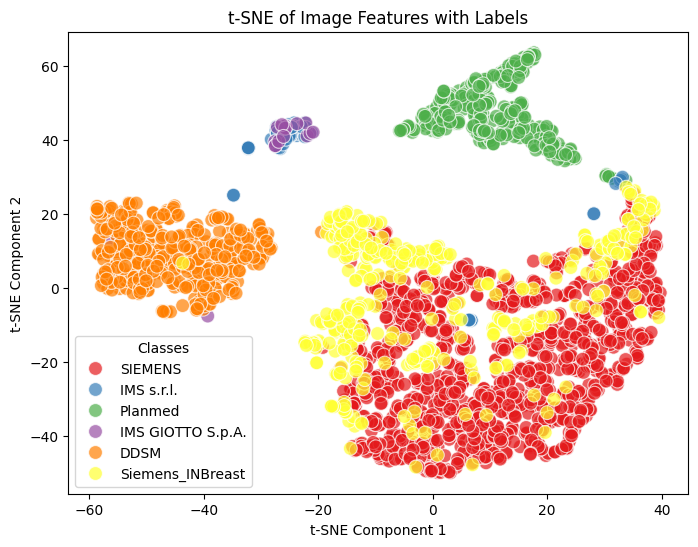

In [5]:
feature_set = image_stats_df.iloc[:,5:]
features = np.array(feature_set)
labels = image_stats_df['vendor'].values
results = run_tsne(features, labels)

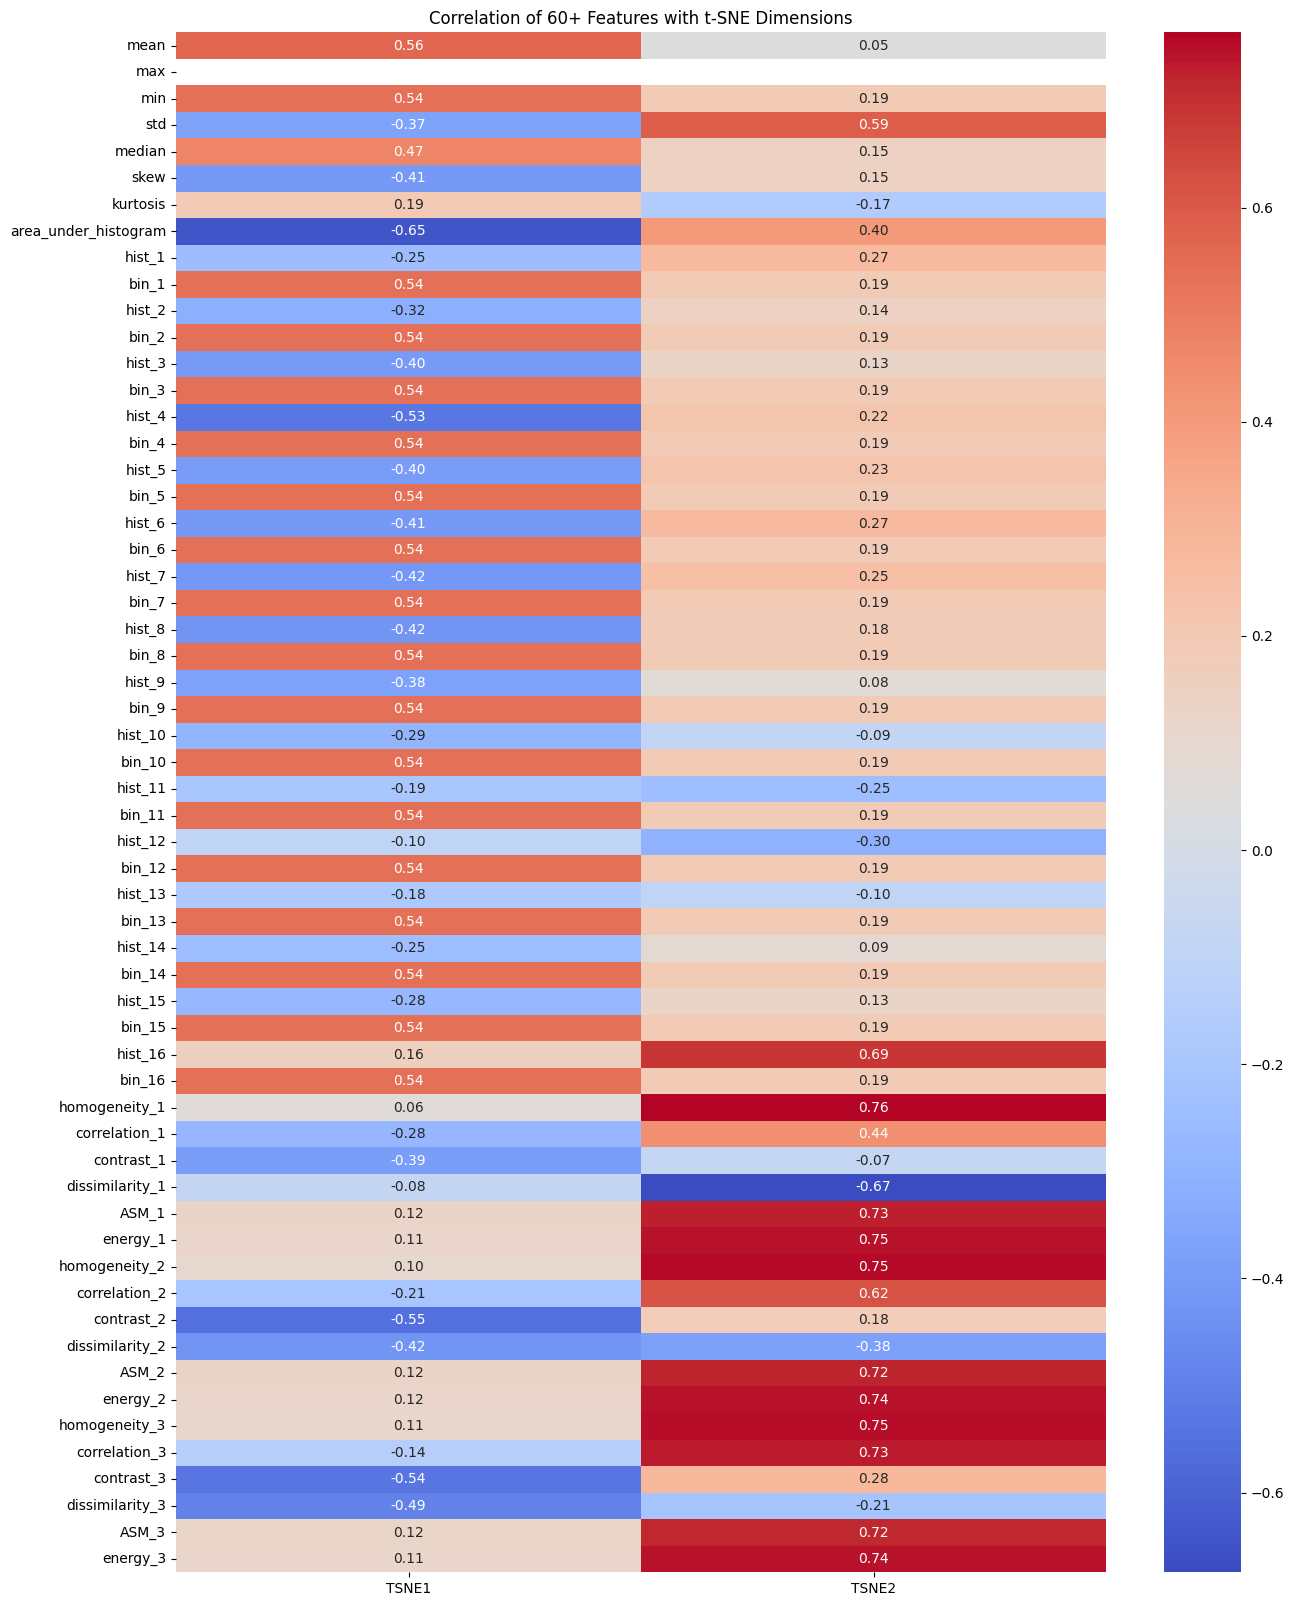

In [6]:
correlations = pd.concat([feature_set, results.iloc[:,:2]], axis=1).corr()
tsne_corr = correlations.loc[feature_set.columns, results.iloc[:,:2].columns]
plt.figure(figsize=(15, 20))
sns.heatmap(tsne_corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation of 60+ Features with t-SNE Dimensions")
plt.show()

<h4>TSNE without the histogram features</h4>

/Users/taha/Library/Python/3.9/lib/python/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


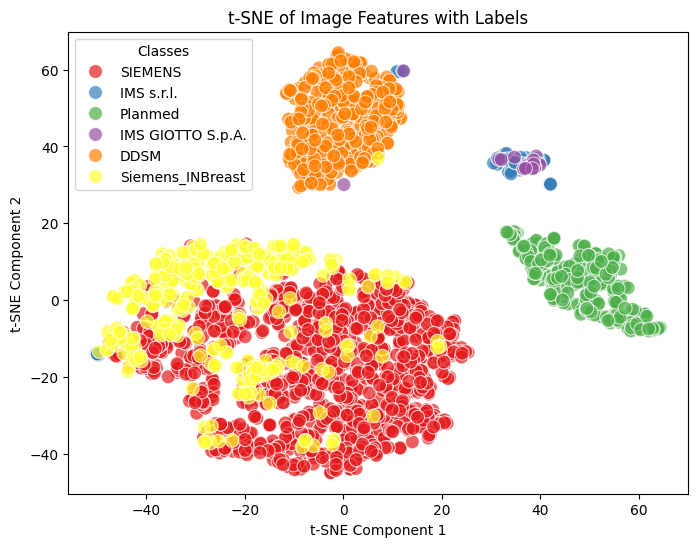

In [7]:
hist_features = ['hist_'+str(i+1) for i in range(16)]
bin_features = ['bin_'+str(i+1) for i in range(16)]
features_to_keep = image_stats_df.drop(columns=hist_features+bin_features)
feature_set = features_to_keep.iloc[:,5:]
features = np.array(feature_set)
labels = image_stats_df['vendor'].values
results = run_tsne(features, labels)

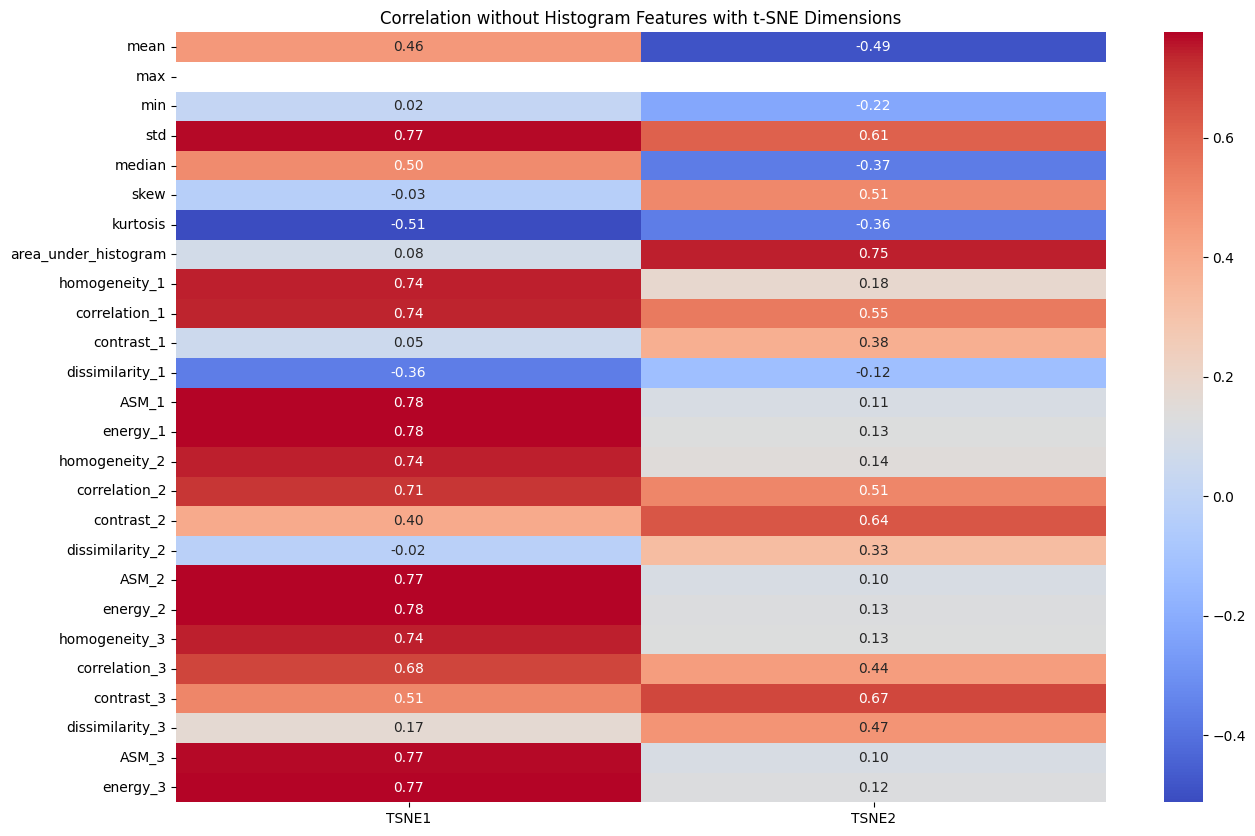

In [8]:
correlations = pd.concat([feature_set, results.iloc[:,:2]], axis=1).corr()
tsne_corr = correlations.loc[feature_set.columns, results.iloc[:,:2].columns]
plt.figure(figsize=(15, 10))
sns.heatmap(tsne_corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation without Histogram Features with t-SNE Dimensions")
plt.show()

<h4>TSNE with only minimum features</h4>

/Users/taha/Library/Python/3.9/lib/python/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


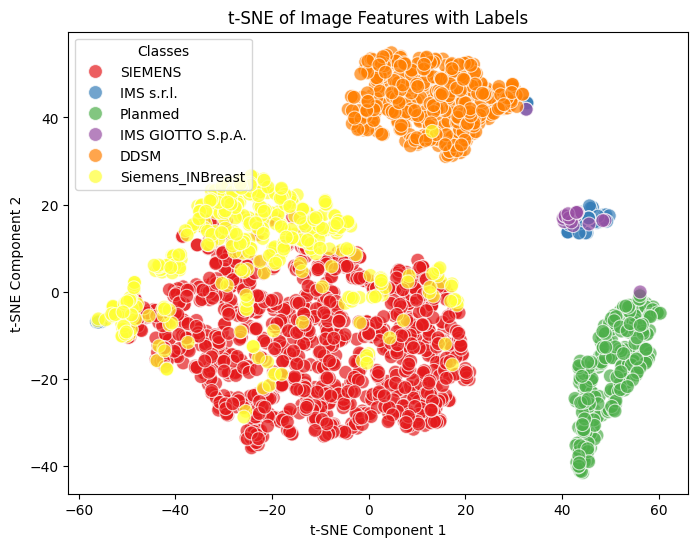

In [9]:
min_features = ['mean', 'std', 'kurtosis', 'area_under_histogram', 'homogeneity_1', 'correlation_2', 'contrast_2', 'dissimilarity_3', 'ASM_2']
feature_set = image_stats_df[min_features]
features = np.array(feature_set)
labels = image_stats_df['vendor'].values
results = run_tsne(features, labels)

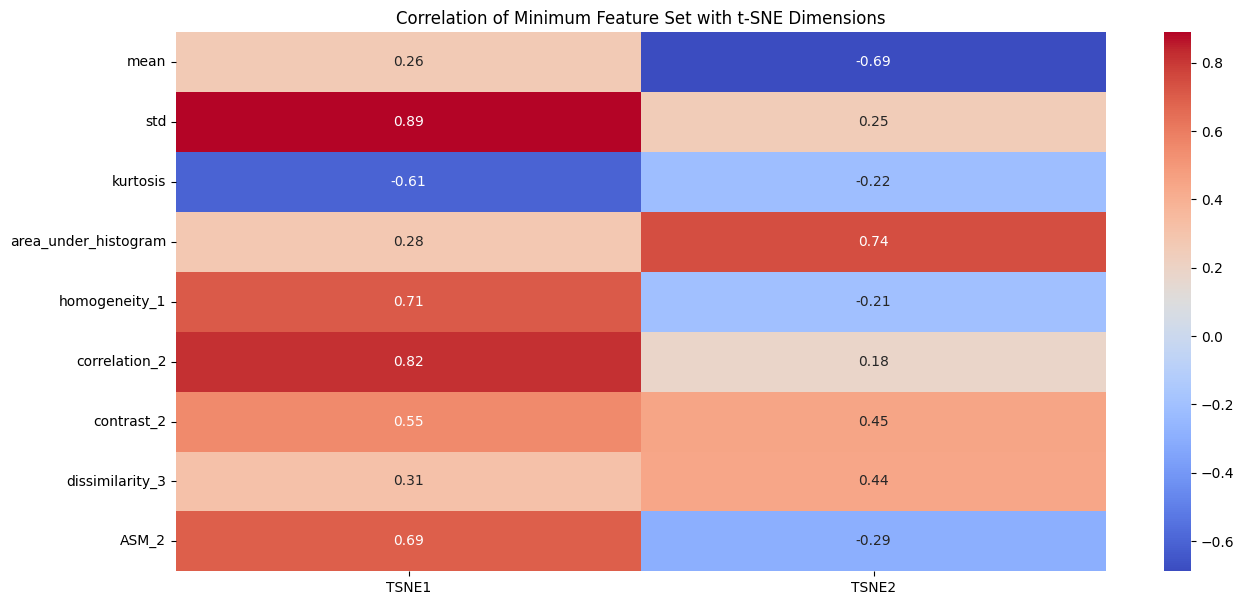

In [10]:
correlations = pd.concat([feature_set, results.iloc[:,:2]], axis=1).corr()
tsne_corr = correlations.loc[feature_set.columns, results.iloc[:,:2].columns]
plt.figure(figsize=(15, 7))
sns.heatmap(tsne_corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation of Minimum Feature Set with t-SNE Dimensions")
plt.show()

<h3>NN Classifier for Class Prediction</h3>

In [100]:
if(load):
    image_stats_df = pd.read_csv('complete_stats_normalized.csv')

In [101]:
image_stats_df['vendor'] = image_stats_df['vendor'].replace(['IMS s.r.l.', 'IMS GIOTTO S.p.A.'], 'IMS')

In [102]:
df = image_stats_df.groupby('vendor').sample(n=70, random_state=42)

In [103]:
# df = image_stats_df[['mean', 'std', 'kurtosis', 'area_under_histogram', 'homogeneity_1', 'correlation_2', 'contrast_2', 'dissimilarity_3', 'ASM_2', 'vendor']].copy()

In [ ]:
# clahe: https://scikit-image.org/docs/0.24.x/api/skimage.exposure.html#skimage.exposure.equalize_adapthist

In [106]:
scaler = StandardScaler()
X = scaler.fit_transform(df.drop(columns=['file_name', 'vendor', 'laterality', 'view_position', 'breast_density']))
le = LabelEncoder()
y = le.fit_transform(df['vendor'])

In [107]:
X_train, X_test, y_train, y_test = train_test_split(X, y , test_size=0.2, random_state=42)

In [108]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


In [109]:
input_size = X_train.shape[1]
num_classes = len(np.unique(y))

In [110]:
model = nn.Sequential(
    nn.Linear(input_size, 64), 
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(64, 32),         
    nn.ReLU(),
    nn.Linear(32, num_classes) 
)

In [111]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
train_metrics = {"loss": [], "accuracy": [], "f1": []}
test_metrics = {"loss": [], "accuracy": [], "f1": []}

In [113]:
patience = 5
min_delta = 0.001
best_loss = float('inf')
epochs_no_improve = 0
early_stop = False

In [ ]:
for epoch in tqdm(range(200)):
    if early_stop:
        print(f"Early stopping at epoch {epoch + 1}")
        break

    # Training phase
    model.train()
    running_loss = 0.0
    y_true_train, y_pred_train = [], []

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        y_true_train.extend(labels.cpu().numpy())
        y_pred_train.extend(preds.cpu().numpy())

    # Calculate training metrics
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = accuracy_score(y_true_train, y_pred_train)
    epoch_f1 = f1_score(y_true_train, y_pred_train, average='weighted')


    train_metrics["loss"].append(epoch_loss)
    train_metrics["accuracy"].append(epoch_accuracy)
    train_metrics["f1"].append(epoch_f1)

    # Early stopping check
    if best_loss - epoch_loss > min_delta:
        best_loss = epoch_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            early_stop = True

 17%|█▋        | 34/200 [00:00<00:01, 133.29it/s]

Early stopping at epoch 35


In [ ]:
# Evaluation Loop
model.eval()
running_loss = 0.0
y_true_test, y_pred_test = [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        y_true_test.extend(labels.cpu().numpy())
        y_pred_test.extend(preds.cpu().numpy())

# Calculate metrics for test set
test_loss = running_loss / len(test_loader)
test_accuracy = accuracy_score(y_true_test, y_pred_test)
test_f1 = f1_score(y_true_test, y_pred_test, average='weighted')



test_metrics["loss"].append(test_loss)
test_metrics["accuracy"].append(test_accuracy)
test_metrics["f1"].append(test_f1)

print(f"Test Metrics - Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.4f}, F1: {test_f1:.4f}")

Test Metrics - Loss: 0.1416, Accuracy: 0.9429, F1: 0.9432, Precision: 0.9455, Recall: 0.9429


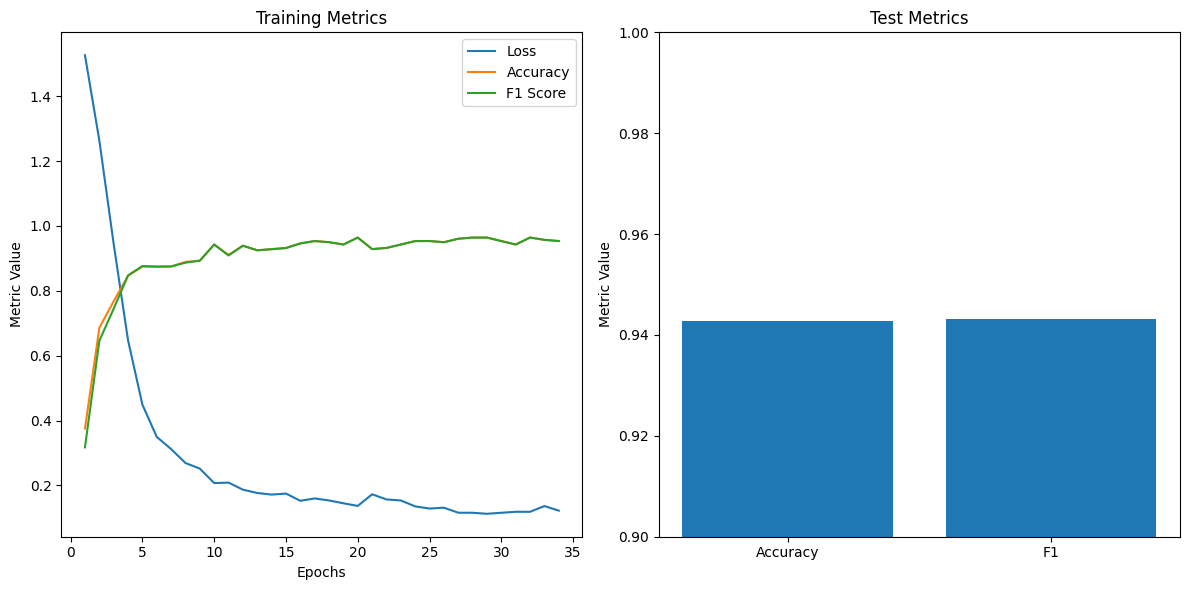

In [119]:
epochs = range(1, len(train_metrics["loss"]) + 1)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_metrics["loss"], label="Loss")
plt.plot(epochs, train_metrics["accuracy"], label="Accuracy")
plt.plot(epochs, train_metrics["f1"], label="F1 Score")
plt.title("Training Metrics")
plt.xlabel("Epochs")
plt.ylabel("Metric Value")
plt.legend()

# Plot test metrics
plt.subplot(1, 2, 2)
plt.bar(["Accuracy", "F1"], 
        [test_metrics["accuracy"][0], 
         test_metrics["f1"][0], 
        ])
plt.title("Test Metrics")
plt.ylabel("Metric Value")
plt.ylim(0.9, 1)

plt.tight_layout()
plt.show()

In [117]:
from sklearn.metrics import confusion_matrix, classification_report

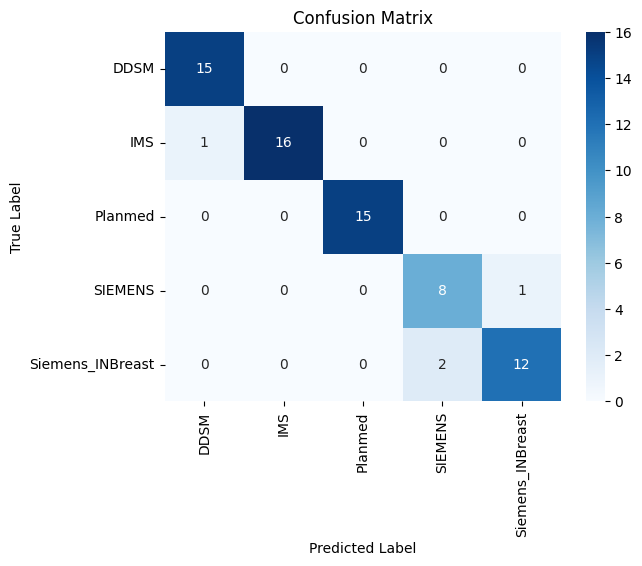

                  precision    recall  f1-score   support

            DDSM       0.94      1.00      0.97        15
             IMS       1.00      0.94      0.97        17
         Planmed       1.00      1.00      1.00        15
         SIEMENS       0.80      0.89      0.84         9
Siemens_INBreast       0.92      0.86      0.89        14

        accuracy                           0.94        70
       macro avg       0.93      0.94      0.93        70
    weighted avg       0.95      0.94      0.94        70



In [118]:
model.eval()
y_true_test, y_pred_test = [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        y_true_test.extend(labels.cpu().numpy())
        y_pred_test.extend(preds.cpu().numpy())

# Confusion Matrix
cm = confusion_matrix(y_true_test, y_pred_test)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print(classification_report(y_true_test, y_pred_test, target_names=le.classes_))